<a href="https://colab.research.google.com/github/ougrid/my-knowledge-resource/blob/master/Pruned_and_Quantized_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pruned and Quantized Transfer Learning for Computer Vision Tutorial
===================================================================
**Author**: [Kullawat Chaowanawatee](https://gitlab.com/e29qwg)

**Origianl Tutorials**:
- [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html) by [Zafar Takhirov](https://github.com/z-a-f) (Reviewer: [Raghuraman Krishnamoorthi](https://github.com/raghuramank100), Editor: [Jessica Lin](https://github.com/jlin27))
- [PyTorch Pruning](https://leimao.github.io/blog/PyTorch-Pruning/) by [Lei Mao](https://github.com/leimao)
- [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), written by [Sasank Chilamkurthy](https://chsasank.github.io/)

This tutorial builds on the original tutorials cited above.
Transfer learning refers to techniques that make use of a pretrained model for
application on a different data-set.
There are two main ways the transfer learning is used:
1. **ConvNet as a fixed feature extractor**: Here, you ["freeze"](https://arxiv.org/abs/1706.04983)
   the weights of all the parameters in the network except that of the final
   several layers (aka “the head”, usually fully connected layers).
   These last layers are replaced with new ones initialized with random
   weights and only these layers are trained.
2. **Finetuning the ConvNet**: Instead of random initializaion, the model is
   initialized using a pretrained network, after which the training proceeds as
   usual but with a different dataset.
   Usually the head (or part of it) is also replaced in the network in
   case there is a different number of outputs.
   It is common in this method to set the learning rate to a smaller number.
   This is done because the network is already trained, and only minor changes
   are required to "finetune" it to a new dataset.
   
You can also combine the above two methods:
First you can freeze the feature extractor, and train the head. After
that, you can unfreeze the feature extractor (or part of it), set the
learning rate to something smaller, and continue training.

In this part you will use the first method – extracting the features
using a quantized model.

In [ ]:
# Imports
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time

plt.ion()

## Part 0. Prerequisites

Before diving into the transfer learning, let us review the "prerequisites",
such as installations and data loading/visualizations.

### Installing the Nightly Build

Because you will be using the experimental parts of the PyTorch, it is
recommended to install the latest version of ``torch`` and
``torchvision``. You can find the most recent instructions on local
installation [here](https://pytorch.org/get-started/locally/).
For example, to install without GPU support:

```shell
   pip install numpy
   pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
   # For CUDA support use https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
```

In [ ]:
# !yes y | pip uninstall torch torchvision
# !yes y | pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

### Load Data

**Note:** This section is identical to the original transfer learning tutorial.
We will use ``torchvision`` and ``torch.utils.data`` packages to load
the data.

The problem you are going to solve today is classifying **ants** and
**bees** from images. The dataset contains about 120 training images
each for ants and bees. There are 75 validation images for each class.
This is considered a very small dataset to generalize on. However, since
we are using transfer learning, we should be able to generalize
reasonably well.

*This dataset is a very small subset of imagenet.*

**Note:** Download the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
  and extract it to the ``data`` directory. 


In [ ]:
import requests
import os
import zipfile

DATA_URL = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
DATA_PATH = os.path.join('.', 'data')
FILE_NAME = os.path.join(DATA_PATH, 'hymenoptera_data.zip')

if not os.path.isfile(FILE_NAME):
  print("Downloading the data...")
  os.makedirs('data', exist_ok=True)
  with requests.get(DATA_URL) as req:
    with open(FILE_NAME, 'wb') as f:
      f.write(req.content)
  if 200 <= req.status_code < 300:
    print("Download complete!")
  else:
    print("Download failed!")
else:
  print(FILE_NAME, "already exists, skipping download...")

with zipfile.ZipFile(FILE_NAME, 'r') as zip_ref:
  print("Unzipping...")
  zip_ref.extractall('data')

DATA_PATH = os.path.join(DATA_PATH, 'hymenoptera_data')

./data/hymenoptera_data.zip already exists, skipping download...
Unzipping...


In [ ]:
import torch
from torchvision import transforms, datasets

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualize a few images


Let's visualize a few training images so as to understand the data
augmentations.



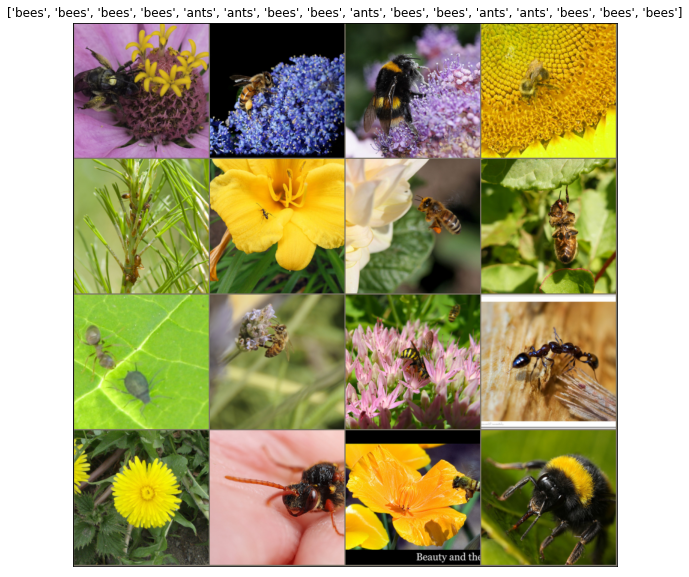

In [ ]:
import torchvision

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes], ax=ax)

### Support Functions for Model Training and Evaluation

Belows are generic functions for model training and evaluation.



In [ ]:
from torch import nn

def create_combined_model(model_fe):
  # Step 1. Isolate the feature extractor.
  model_fe_features = nn.Sequential(
    model_fe.quant,  # Quantize the input
    model_fe.conv1,
    model_fe.bn1,
    model_fe.relu,
    model_fe.maxpool,
    model_fe.layer1,
    model_fe.layer2,
    model_fe.layer3,
    model_fe.layer4,
    model_fe.avgpool,
    model_fe.dequant,  # Dequantize the output
  )

  # Step 2. Create a new "head"
  new_head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2),
  )

  # Step 3. Combine, and don't forget the quant stubs.
  new_model = nn.Sequential(
    model_fe_features,
    nn.Flatten(1),
    new_head,
  )
  return new_model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
      """
      Support function for model training.

      Args:
        model: Model to be trained
        criterion: Optimization criterion (loss)
        optimizer: Optimizer to use for training
        scheduler: Instance of ``torch.optim.lr_scheduler``
        num_epochs: Number of epochs
        device: Device to run the training on. Must be 'cpu' or 'cuda'
      """
      since = time.time()

      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0

      for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
          if phase == 'train':
            model.train()  # Set model to training mode
          else:
            model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              if phase == 'train':
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
          if phase == 'train':
            scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = running_corrects.double() / dataset_sizes[phase]

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
      print('Best val Acc: {:4f}'.format(best_acc))

      # load best model weights
      model.load_state_dict(best_model_wts)
      return model

In [ ]:
def evaluate_model(model, criterion, device='cpu'):
      """
      Support function for model evaluation.

      Args:
        model: Model to be trained
        device: Device to run the training on. Must be 'cpu' or 'cuda'
      """
      best_acc = 0.0

      with torch.no_grad():
          model.eval()   # Set model to evaluate mode

          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward the model
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # statistics
            running_corrects += torch.sum(preds == labels.data)
      
      eval_acc = running_corrects.double() / dataset_sizes['val']
      return eval_acc

### Support Function for Visualizing the Model Predictions

Generic function to display predictions for a few images




In [ ]:
 def visualize_model(model, rows=3, cols=3):
      was_training = model.training
      model.eval()
      current_row = current_col = 0
      fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

      with torch.no_grad():
        for idx, (imgs, lbls) in enumerate(dataloaders['val']):
          imgs = imgs.cpu()
          lbls = lbls.cpu()

          outputs = model(imgs)
          _, preds = torch.max(outputs, 1)

          for jdx in range(imgs.size()[0]):
            imshow(imgs.data[jdx], ax=ax[current_row, current_col])
            ax[current_row, current_col].axis('off')
            ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds[jdx]]))

            current_col += 1
            if current_col >= cols:
              current_row += 1
              current_col = 0
            if current_row >= rows:
              model.train(mode=was_training)
              return
        model.train(mode=was_training)


## Part 1. Baseline Model

### Model Preparation

In [ ]:
import torchvision.models.quantization as models

model = models.resnet18(pretrained=True, progress=True, quantize=False)
num_ftrs = model.fc.in_features
model.train()

# Freeze
for param in model.parameters():
  param.requires_grad = False

# Step 1. Isolate the feature extractor.
orig_model_features = nn.Sequential(
  model.conv1,
  model.bn1,
  model.relu,
  model.maxpool,
  model.layer1,
  model.layer2,
  model.layer3,
  model.layer4,
  model.avgpool,
)

# Step 2. Create a new "head"
new_head = nn.Sequential(
  nn.Dropout(p=0.5),
  nn.Linear(num_ftrs, 2),
)

# Step 3. Combine
orig_model = nn.Sequential(
  orig_model_features,
  nn.Flatten(1),
  new_head,
)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.optim as optim

orig_model.to(device);

criterion = nn.CrossEntropyLoss()

# Note that we are only training the head.
optimizer_ft = optim.SGD(orig_model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.05 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.05)

### Training

In [ ]:
orig_model = train_model(orig_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=25, device=device)

# change device to perform benchmark later
orig_model.to('cpu');

Epoch 0/24
----------
train Loss: 0.5323 Acc: 0.7254
val Loss: 0.8437 Acc: 0.7255

Epoch 1/24
----------
train Loss: 0.5774 Acc: 0.8279
val Loss: 0.6573 Acc: 0.8039

Epoch 2/24
----------
train Loss: 0.4218 Acc: 0.8525
val Loss: 0.9390 Acc: 0.8170

Epoch 3/24
----------
train Loss: 1.3317 Acc: 0.7623
val Loss: 0.6329 Acc: 0.9216

Epoch 4/24
----------
train Loss: 1.4813 Acc: 0.8033
val Loss: 0.4729 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.8814 Acc: 0.8811
val Loss: 0.6559 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.6423 Acc: 0.9016
val Loss: 0.5588 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.5658 Acc: 0.9180
val Loss: 0.5635 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.4998 Acc: 0.8975
val Loss: 0.5701 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.5178 Acc: 0.9180
val Loss: 0.6385 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.4671 Acc: 0.9057
val Loss: 0.6615 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2933 Acc: 0.9467
val Loss: 0.5735 Acc: 0.9412

Ep

### Visualize model

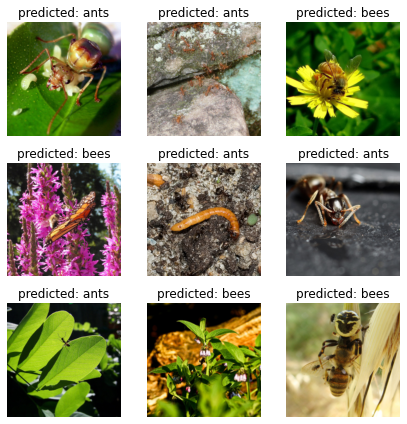

In [ ]:
visualize_model(orig_model)

plt.ioff()
plt.tight_layout()
plt.show()

## Part 2. Pruning the Model

In [ ]:
#@title Measuring Module Sparsity Function

def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):
    num_zeros = 0
    num_elements = 0
    
    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()
            if "bias" in param_name and bias == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()
    
    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity

In [ ]:
#@title Measuring Global Sparsity Function
def measure_global_sparsity(model,
                            weight=True,
                            bias=False,
                            conv2d_use_mask=False,
                            linear_use_mask=False):

    num_zeros = 0
    num_elements = 0

    for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):
            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=conv2d_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.Linear):
            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=linear_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity

In [ ]:
#@title Pruning and Fine-tuning Function

import torch.nn.utils.prune as prune

def iterative_pruning_finetuning(model,
                                 criterion,
                                 device,
                                 optimizer,
                                 lr_scheduler,
                                 conv2d_prune_amount=0.2,
                                 linear_prune_amount=0.4,
                                 num_iterations=10,
                                 num_epochs_per_iteration=25,
                                 global_pruning=False):

    for i in range(num_iterations):

        print("Pruning and Finetuning {}/{}".format(i + 1, num_iterations))

        print("Pruning...")

        if global_pruning == True:
            parameters_to_prune = []
            
            for module_name, module in model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    parameters_to_prune.append((module, "weight"))
            
            prune.global_unstructured(
                parameters_to_prune,
                pruning_method=prune.L1Unstructured,
                amount=conv2d_prune_amount,
            )
        else:
            for module_name, module in model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    prune.l1_unstructured(module, name="weight",
                                          amount=conv2d_prune_amount)
                elif isinstance(module, torch.nn.Linear):
                    prune.l1_unstructured(module, name="weight",
                                          amount=linear_prune_amount)

        eval_accuracy = evaluate_model(model, criterion, device=device)

        num_zeros, num_elements, sparsity = measure_global_sparsity(
            model,
            weight=True,
            bias=False,
            conv2d_use_mask=True,
            linear_use_mask=False)

        print(f"Test Accuracy: {eval_accuracy}")
        print("Global Sparsity: {:.2f}".format(sparsity))

        print("Fine-tuning...")

        train_model(model, criterion, optimizer, lr_scheduler,
                    device=device,
                    num_epochs=num_epochs_per_iteration)

        eval_accuracy = evaluate_model(model, criterion, device=device)

        num_zeros, num_elements, sparsity = measure_global_sparsity(
            model,
            weight=True,
            bias=False,
            conv2d_use_mask=True,
            linear_use_mask=False)

        print(f"Test Accuracy: {eval_accuracy}")
        print("Global Sparsity: {:.2f}".format(sparsity))

    return model

In [ ]:
#@title Remove Parameters Marked as Pruned
def remove_parameters(model):
    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass

    return model

### Prune the model

In [ ]:
pruned_model = copy.deepcopy(orig_model)

pruned_model.to(device)

criterion = nn.CrossEntropyLoss()

# Lower learning rate for fine-tuning
optimizer_pr = optim.SGD(pruned_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_pr, step_size=5, gamma=0.3)

pruned_model = iterative_pruning_finetuning(
    model = pruned_model,
    criterion = criterion,
    optimizer = optimizer_pr,
    lr_scheduler = exp_lr_scheduler,
    num_iterations = 2,  # 2 iterations
    num_epochs_per_iteration = 25, # 25 epochs each
    device = device,
)

backup_pruned_model = copy.deepcopy(pruned_model)
pruned_model = remove_parameters(pruned_model)

pruned_model.to('cpu');

Pruning and Finetuning 1/3
Pruning...
Test Accuracy: 0.9477124183006537
Global Sparsity: 0.40
Fine-tuning...
Epoch 0/24
----------
train Loss: 0.7094 Acc: 0.8811
val Loss: 0.4511 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.6490 Acc: 0.8975
val Loss: 0.4459 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.5442 Acc: 0.9016
val Loss: 0.4821 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.6925 Acc: 0.8811
val Loss: 0.4686 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4725 Acc: 0.9016
val Loss: 0.4064 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4758 Acc: 0.8770
val Loss: 0.4196 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.6288 Acc: 0.8648
val Loss: 0.4307 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.5530 Acc: 0.9098
val Loss: 0.4383 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.5225 Acc: 0.8852
val Loss: 0.4450 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3224 Acc: 0.9303
val Loss: 0.4741 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3621 Acc: 0.9180
val Los

### Visualize model

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


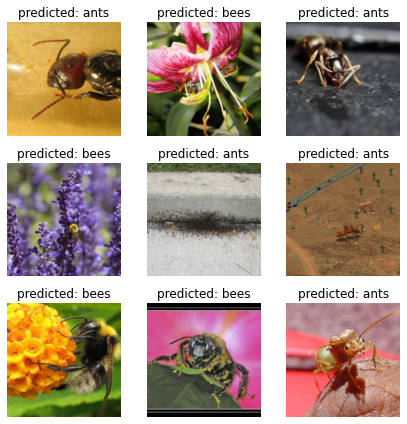

In [ ]:
visualize_model(pruned_model)

plt.ioff()
plt.tight_layout()
plt.show()

### Pruning Speedup Benchmark

A little speedup here (sometimes it is worse), due to the model size is small
and we use **unstructured** pruning.
By the way, notice the 78% sparsity which means many weights and biases are zeros.

Also note that we can use channel pruning (**structured**) to gain more speedup
 (see [Model Pruning](https://nni.readthedocs.io/en/stable/compression/pruning.html) for more in-depth).

In [ ]:
#@title
all_models = [orig_model, pruned_model]
models_names = ['Original model', 'Pruned Model']

# Random input data
x = torch.randn(1, 3, 224, 224)

for (_m, _m_name) in zip(all_models, models_names):
  _m.to('cpu')
  print('--- {} ---'.format(_m_name))
  eval_acc = evaluate_model(_m, criterion, device='cpu')
  num_zeros, num_elements, sparsity = measure_global_sparsity(_m)
  print("Global Sparsity: {:.2f}".format(sparsity))
  print('{} accuracy: {:.4f}'.format(_m_name, eval_acc))
  %timeit _m(x)
  print('')

--- Original model ---
Global Sparsity: 0.00
Original model accuracy: 0.9412
55.9 ms ± 7.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

--- Pruned Model ---
Global Sparsity: 0.78
Pruned Model accuracy: 0.8627
52.6 ms ± 605 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)



## Part 3. Training a Custom Classifier based on a Quantized Feature Extractor 

In this section you will use a “frozen” quantized feature extractor, and
train a custom classifier head on top of it. Unlike floating point
models, you don’t need to set requires_grad=False for the quantized
model, as it has no trainable parameters. Please, refer to the[documentation](https://pytorch.org/docs/stable/quantization.html) for
more details.

Load a pretrained model: for this exercise you will be using [ResNet-18](https://pytorch.org/hub/pytorch_vision_resnet/).



In [ ]:
import torchvision.models.quantization as models

# We will need the number of filters in the `fc` for future use.
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_fe = models.resnet18(pretrained=True, progress=True, quantize=True)
num_ftrs = model_fe.fc.in_features

At this point you need to modify the pretrained model. The model
has the quantize/dequantize blocks in the beginning and the end. However,
because you will only use the feature extractor, the dequantizatioin layer has
to move right before the linear layer (the head). The easiest way to do that
is to wrap the model in the ``nn.Sequential`` module.

The first step is to isolate the feature extractor in the ResNet
model. Although in this example you are tasked to use all layers except
``fc`` as the feature extractor, in reality, you can take as many parts
as you need. This would be useful in case you would like to replace some
of the convolutional layers as well.

**Note:** When separating the feature extractor from the rest of a quantized
   model, you have to manually place the quantizer/dequantized in the
   beginning and the end of the parts you want to keep quantized.

**Warning:** Currently the quantized models can only be run on CPU.
  However, it is possible to send the non-quantized parts of the model to a GPU.

In [ ]:
new_model = create_combined_model(model_fe)
new_model = new_model.to('cpu')

criterion = nn.CrossEntropyLoss()

# Note that we are only training the head.
optimizer_ft = optim.SGD(new_model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate

This step takes around 5-15 min on CPU. Because the quantized model can
only run on the CPU, you cannot run the training on GPU.


In [ ]:
new_model = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=25, device='cpu')

Epoch 0/24
----------
train Loss: 0.8903 Acc: 0.7172
val Loss: 0.3831 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.5253 Acc: 0.8975
val Loss: 0.4853 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.6567 Acc: 0.9057
val Loss: 0.4570 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.5344 Acc: 0.9180
val Loss: 0.4340 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.5295 Acc: 0.9016
val Loss: 0.7061 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.2856 Acc: 0.9303
val Loss: 0.5372 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.4635 Acc: 0.9180
val Loss: 0.4798 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.2501 Acc: 0.9590
val Loss: 0.5321 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3108 Acc: 0.9467
val Loss: 0.5594 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3292 Acc: 0.9508
val Loss: 0.5402 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2057 Acc: 0.9713
val Loss: 0.5196 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.2842 Acc: 0.9467
val Loss: 0.4905 Acc: 0.9477

Ep

In [ ]:
quantized_model = new_model
eval_acc = evaluate_model(quantized_model, criterion, device='cpu')
print(f'Accuracy: {eval_acc}')

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy: 0.954248366013072


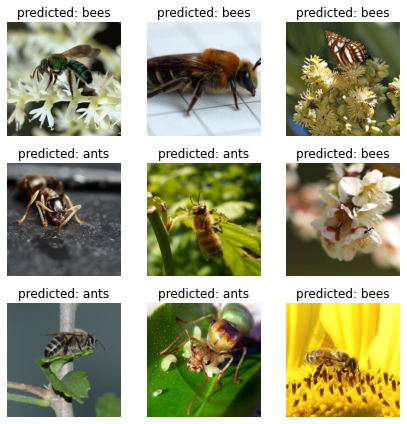

In [ ]:
visualize_model(quantized_model)
plt.tight_layout()

## Part 4. Fine-tuning the Quantizable Model

In this part, we fine tune the feature extractor used for transfer
learning, and quantize the feature extractor. Note that in both part 1
and 2, the feature extractor is quantized. The difference is that in
part 1, we use a pretrained quantized model. In this part, we create a
quantized feature extractor after fine tuning on the data-set of
interest, so this is a way to get better accuracy with transfer learning
while having the benefits of quantization. Note that in our specific
example, the training set is really small (120 images) so the benefits
of fine tuning the entire model is not apparent. However, the procedure
shown here will improve accuracy for transfer learning with larger
datasets.

The pretrained feature extractor must be quantizable.
To make sure it is quantizable, perform the following steps:

 1. Fuse ``(Conv, BN, ReLU)``, ``(Conv, BN)``, and ``(Conv, ReLU)`` using
    ``torch.quantization.fuse_modules``.
 2. Connect the feature extractor with a custom head.
    This requires dequantizing the output of the feature extractor.
 3. Insert fake-quantization modules at appropriate locations
    in the feature extractor to mimic quantization during training.

For step (1), we use models from ``torchvision/models/quantization``, which
have a member method ``fuse_model``. This function fuses all the ``conv``,
``bn``, and ``relu`` modules. For custom models, this would require calling
the ``torch.quantization.fuse_modules`` API with the list of modules to fuse
manually.

Step (2) is performed by the ``create_combined_model`` function
used in the previous section.

Step (3) is achieved by using ``torch.quantization.prepare_qat``, which
inserts fake-quantization modules.


As step (4), you can start "finetuning" the model, and after that convert
it to a fully quantized version (Step 5).

To convert the fine tuned model into a quantized model you can call the
``torch.quantization.convert`` function (in our case only
the feature extractor is quantized).

**Note:** Because of the random initialization your results might differ from
   the results shown in this tutorial.

In [ ]:
# notice `quantize=False`
model = models.resnet18(pretrained=True, progress=True, quantize=False)
num_ftrs = model.fc.in_features

# Step 1
model.train()
model.fuse_model()
# Step 2
model_ft = create_combined_model(model)
model_ft[0].qconfig = torch.quantization.get_default_qat_qconfig('qnnpack')  # Use default QAT configuration
# Step 3
model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Fine-tuning the model

In the current tutorial the whole model is fine tuned. In
general, this will lead to higher accuracy. However, due to the small
training set used here, we end up overfitting to the training set.


Step 4. Fine tune the model


In [ ]:
for param in model_ft.parameters():
  param.requires_grad = True

model_ft.to(device)  # We can fine-tune on GPU if available

criterion = nn.CrossEntropyLoss()

# Note that we are training everything, so the learning rate is lower
# Notice the smaller learning rate
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.3 every several epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.3)

model_ft_tuned = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                              num_epochs=25, device=device)

Epoch 0/24
----------


/usr/local/lib/python3.8/dist-packages/torch/ao/quantization/fake_quantize.py:309: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at ../aten/src/ATen/native/ReduceAllOps.cpp:45.)
  return torch.fused_moving_avg_obs_fake_quant(


train Loss: 0.6235 Acc: 0.6516
val Loss: 0.2907 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.2941 Acc: 0.8730
val Loss: 0.1996 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.2111 Acc: 0.9180
val Loss: 0.1801 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.0989 Acc: 0.9754
val Loss: 0.2202 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.1171 Acc: 0.9508
val Loss: 0.1650 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.0942 Acc: 0.9754
val Loss: 0.1866 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.0625 Acc: 0.9836
val Loss: 0.1580 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.0676 Acc: 0.9836
val Loss: 0.1671 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.0810 Acc: 0.9795
val Loss: 0.1819 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.0607 Acc: 0.9918
val Loss: 0.1716 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.0594 Acc: 0.9918
val Loss: 0.1701 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.0543 Acc: 0.9959
val Loss: 0.1619 Acc: 0.9542

Epoch 12/24
----------
t

Step 5. Convert to quantized model


In [ ]:
from torch.quantization import convert
model_ft_tuned.cpu()

model_qat = convert(model_ft_tuned, inplace=False)

Lets see how the quantized model performs on a few images


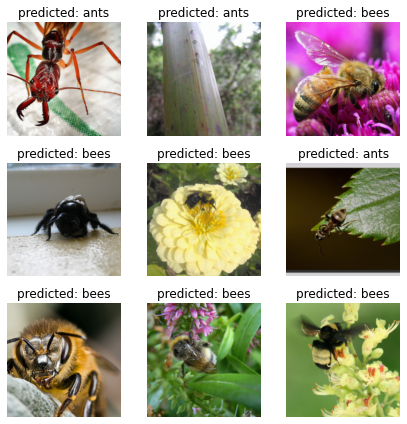

In [ ]:
visualize_model(model_qat)

plt.ioff()
plt.tight_layout()
plt.show()

## Benchmark

Perform transfer learning on ResNet18 to be our benchmark baseline

### Model Accuracy and Inference Time

In [ ]:
#@title
# Random input data
x = torch.randn(1, 3, 224, 224)

all_models = [orig_model, pruned_model, quantized_model, model_qat]
models_names = ['Original model', 'Pruned Model', 'Quantized model', 'QAT model']

for (_m, _m_name) in zip(all_models, models_names):
  eval_acc = evaluate_model(_m, criterion, device='cpu')
  print(f'--- {_m_name} ---')
  print('Accuracy: {:.4f}'.format(eval_acc))
  %timeit _m(x)
  print('')

--- Original model ---
Accuracy: 0.9412
53.8 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

--- Pruned Model ---
Accuracy: 0.8627
52.9 ms ± 808 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

--- Quantized model ---
Accuracy: 0.9542
28.8 ms ± 695 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

--- QAT model ---
Accuracy: 0.9346
30.1 ms ± 4.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

